## Dataset preparation & pre-processing

Questo jnb rappresenta una prima esplorazione dei dati a disposizione, insieme al tenativo di pre-processarli con diverse tecniche di signal processing mutuate da diverse fonti (in particolare: https://bit.ly/2zQEeIg). I dati sono riorganizzati poi in una struttura consona per l'addestramento di un classificatore in scikit-learn.

In [1]:
import os
import sys
import glob

import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [180]:
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.signal import welch
from scipy.signal import butter
from scipy.signal import filtfilt

In [4]:
#from detect_peaks import detect_peaks as dpk

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [6]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [7]:
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

### EDA Exploratory Data Analysis

#### EDA singolo file

In [8]:
# importa un singolo file in un Dataframe di pandas
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
df = pd.read_csv(data_path + file_name, delimiter=',', header=None)

In [9]:
df.head()

,0,1,2,3,4
0,20180920-15:24:10.452,-7464,16632,2060,2111
1,20180920-15:24:10.456,3976,17892,-6080,2115
2,20180920-15:24:10.458,-584,17500,1356,2124
3,20180920-15:24:10.460,-584,17500,1356,2142
4,20180920-15:24:10.462,-584,17500,1356,2143


In [10]:
# rinomina le feature del df
df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)

In [11]:
# trasforma il tipo della feature "date_time" nel formato date_time
df['date_time'] = pd.to_datetime(df['date_time'])

In [12]:
df.shape

(25575, 5)

In [13]:
df.head(), df.tail()

(                date_time     x      y     z     i
 0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
 1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
 2 2018-09-20 15:24:10.458  -584  17500  1356  2124
 3 2018-09-20 15:24:10.460  -584  17500  1356  2142
 4 2018-09-20 15:24:10.462  -584  17500  1356  2143,
                     date_time     x      y     z     i
 25570 2018-09-20 15:25:11.995  1148  16772 -2528  2176
 25571 2018-09-20 15:25:11.997  1148  16772 -2528  2406
 25572 2018-09-20 15:25:12.000  1148  16456   604  2485
 25573 2018-09-20 15:25:12.002   164  16456   604  2407
 25574 2018-09-20 15:25:12.004   164  16456   604  2189)

Plottiamo le time series delle singole variabili misurate in un intervallo a scelta

In [14]:
df.columns.values

array(['date_time', 'x', 'y', 'z', 'i'], dtype=object)

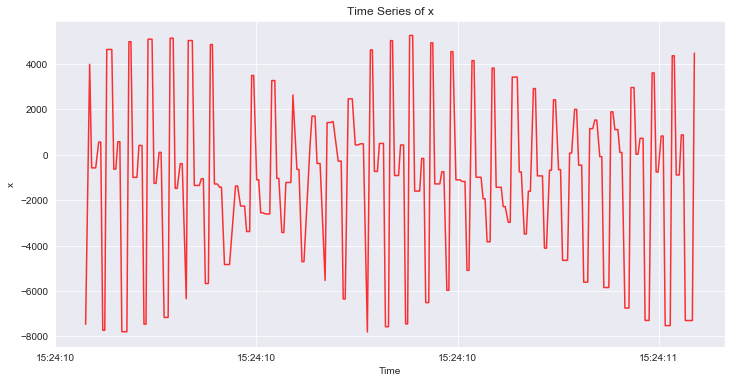

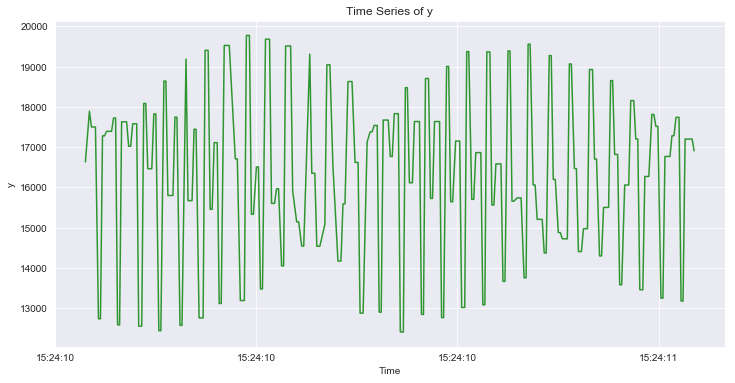

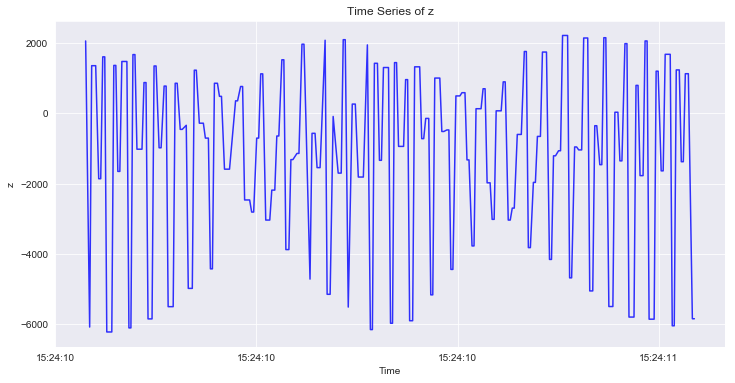

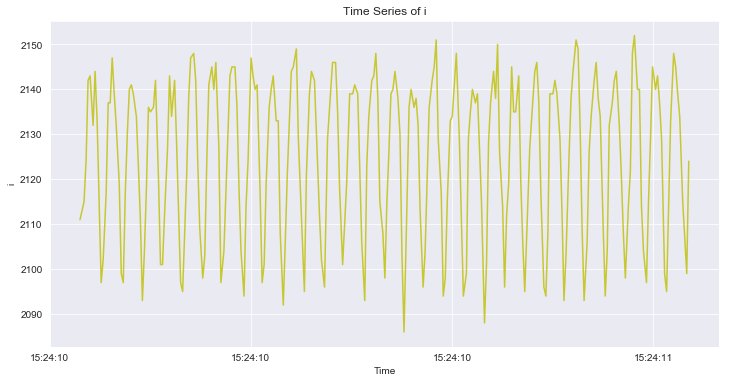

In [15]:
start_time = 0
end_time = 256
variables = df.columns.values[1:]
colors = {'x':'r', 'y':'g', 'z':'b', 'i':'y'}

for var in variables:
    
    plt.figure(figsize=(12,6))
    sns.lineplot(x='date_time', y=var, data=df[start_time:end_time], color=colors[var], alpha=0.8)
    plt.title("Time Series of " + var)
    plt.xlabel("Time")
    plt.ylabel(var)

Plottiamo la distribuzione delle singole variabili

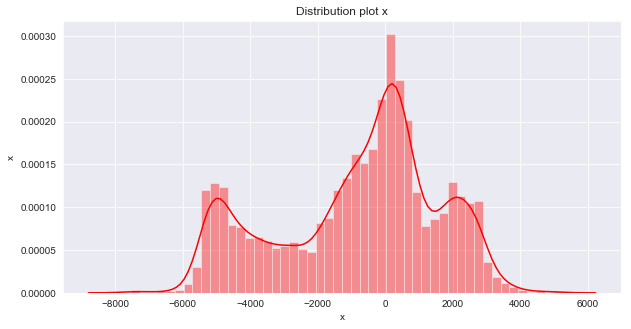

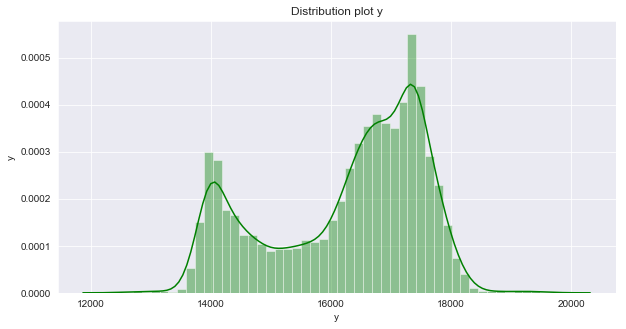

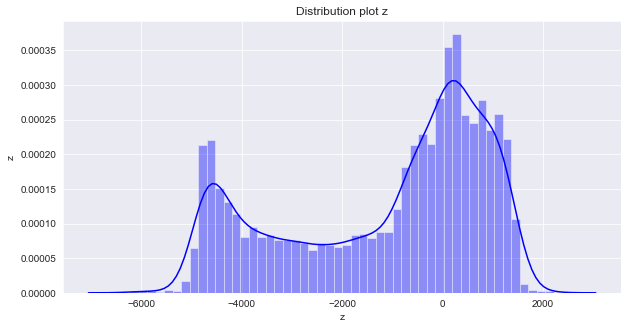

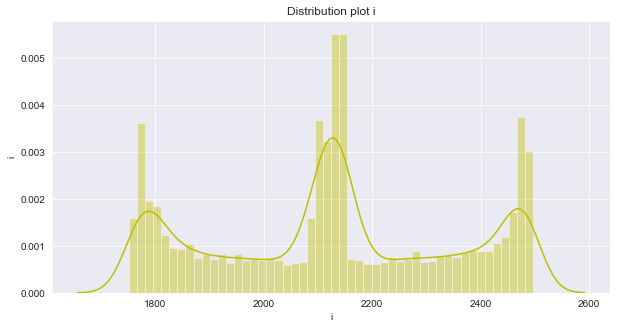

In [16]:
for var in variables:
    
    plt.figure(figsize=(10,5))
    sns.distplot(df[var], bins=50, color=colors[var], norm_hist=True)
    plt.title("Distribution plot " + var)
    plt.xlabel(var)
    plt.ylabel(var)

#### EDA tutti i file

In [17]:
"""
importa tutti i file dei dati .csv, li etichetta
e li concatena in un unico dataframe
"""

all_files = glob.glob(data_path + "/*.csv")

dframe = pd.DataFrame()
f_list = []

for f in all_files:
    
    # skippa i campioni iniziali
    df = pd.read_csv(f, skiprows=1024, delimiter=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    # assegna la label a ciascun sub-dataframe
    df['label'] = f[f.rfind('\\') +1]
    f_list.append(df)

# concatena i singoli df
dframe = pd.concat(f_list)

In [18]:
dframe.head(), dframe.tail()

(                date_time     x      y     z     i label
 0 2018-09-20 15:30:44.194 -3888  13068 -4300  2144     1
 1 2018-09-20 15:30:44.196  -112  15828 -4300  2136     1
 2 2018-09-20 15:30:44.199  -112  15828 -4300  2138     1
 3 2018-09-20 15:30:44.201 -7380  18088  3936  2122     1
 4 2018-09-20 15:30:44.203 -7380  18088  3936  2102     1,
                     date_time     x      y    z     i label
 24547 2018-09-20 15:28:58.065  1012  16352   28  2468     7
 24548 2018-09-20 15:28:58.067  1012  16352   28  2480     7
 24549 2018-09-20 15:28:58.069  1012  15024  780  2294     7
 24550 2018-09-20 15:28:58.071 -2012  15024  780  2070     7
 24551 2018-09-20 15:28:58.074 -2012  15024  780  1838     7)

In [19]:
# elenca il numero di sample per classe dalla più numerosa
dframe.label.value_counts()

5    50127
2    24552
7    24552
6    14322
3     9207
1     9207
4     9207
Name: label, dtype: int64

([<matplotlib.axis.XTick at 0x194df2ca630>,
 <a list of 7 Text xticklabel objects>)

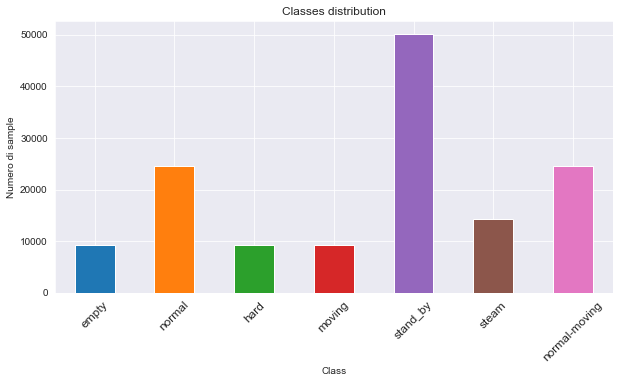

In [20]:
# plotta la distribuzione delle classi (numero di campioni per classe = modalità di funzionamento)
count_classes = pd.value_counts(dframe['label'], sort = True).sort_index()
plt.figure(figsize=(10,5))
count_classes.plot(kind = 'bar')
plt.title("Classes distribution")
plt.xlabel("Class")
plt.ylabel("Numero di sample")
#labels = {'1':'empty', '2':'normal', '3':'hard', '4':'moving', '5':'stand_by', '6':'steam', '7':'normal-moving'}
labels = ['empty', 'normal', 'hard', 'moving', 'stand_by', 'steam', 'normal-moving']
plt.xticks(range(0,7), labels, rotation=45, fontsize=12)

In [21]:
# prende la norma delle componenti del segnale lungo i tre assi
dframe['m'] = np.sqrt(dframe['x']**2 + dframe['y']**2 + dframe['z']**2)

In [22]:
dframe.head()

,date_time,x,y,z,i,label,m
0,2018-09-20 15:30:44.194,-3888,13068,-4300,2144,1,14296.124230
1,2018-09-20 15:30:44.196,-112,15828,-4300,2136,1,16402.076942
2,2018-09-20 15:30:44.199,-112,15828,-4300,2138,1,16402.076942
3,2018-09-20 15:30:44.201,-7380,18088,3936,2122,1,19928.177037
4,2018-09-20 15:30:44.203,-7380,18088,3936,2102,1,19928.177037


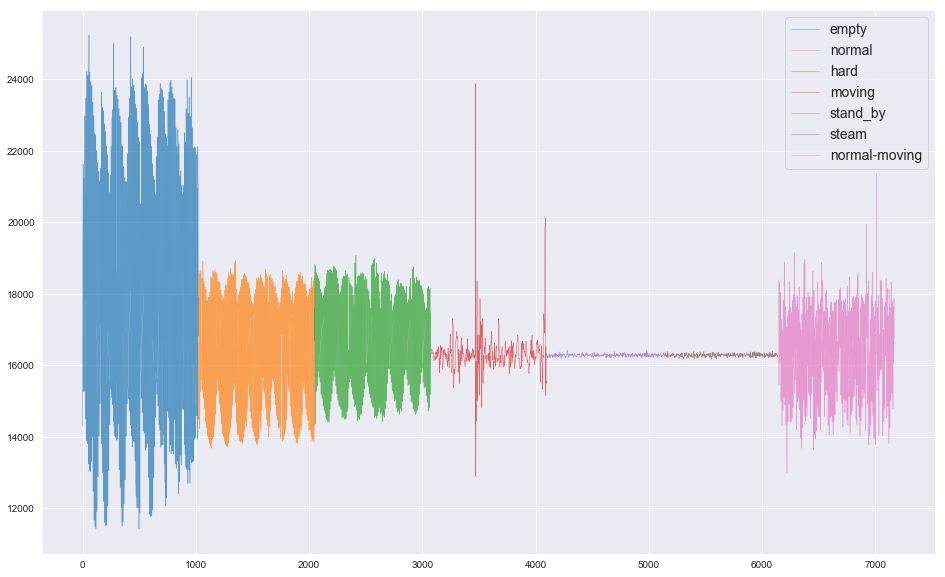

In [23]:
# plotta un certo numero di campioni per ogni modalità di funzionamento
# per visualizzare le forme d'onda 
start_sample = 0
end_sample = 1024

plt.figure(figsize=(16,10))

for c in range(1, 8):
    plt.plot(dframe[dframe['label'] == str(c)]['m'][start_sample:end_sample], 
             linewidth=.5, alpha=0.70)
    start_sample = end_sample
    end_sample = start_sample + 1024

plt.legend(labels, prop={'size': 14})

Visualizziamo le correlazioni tra le variabili x, y, z, raggruppate per label

In [24]:
# ignora l'errore di divisione per zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [25]:
# genera il df per la visualizzazione a coppie
pair_df = dframe.loc[:, ['x','y','z','label']]

In [26]:
labels_dict = {'1':'empty', '2':'normal', '3':'hard', '4':'moving', '5':'stand_by', '6':'steam', '7':'normal-moving'}

In [27]:
pair_df['label'] = pair_df['label'].map(labels_dict)

In [28]:
pair_df.head()

,x,y,z,label
0,-3888,13068,-4300,empty
1,-112,15828,-4300,empty
2,-112,15828,-4300,empty
3,-7380,18088,3936,empty
4,-7380,18088,3936,empty


In [29]:
col_labels_dict = {'empty':'C0', 'normal':'C1', 'hard':'C2', 'moving':'C3', 'stand_by':'C4',
              'steam':'C5', 'normal-moving':'C6'}

In [30]:
# seleziona le label per il pair plot in base a labels_dict
sel_labels = [1, 2, 3]
hue_order = [labels_dict[str(i)] for i in sel_labels]

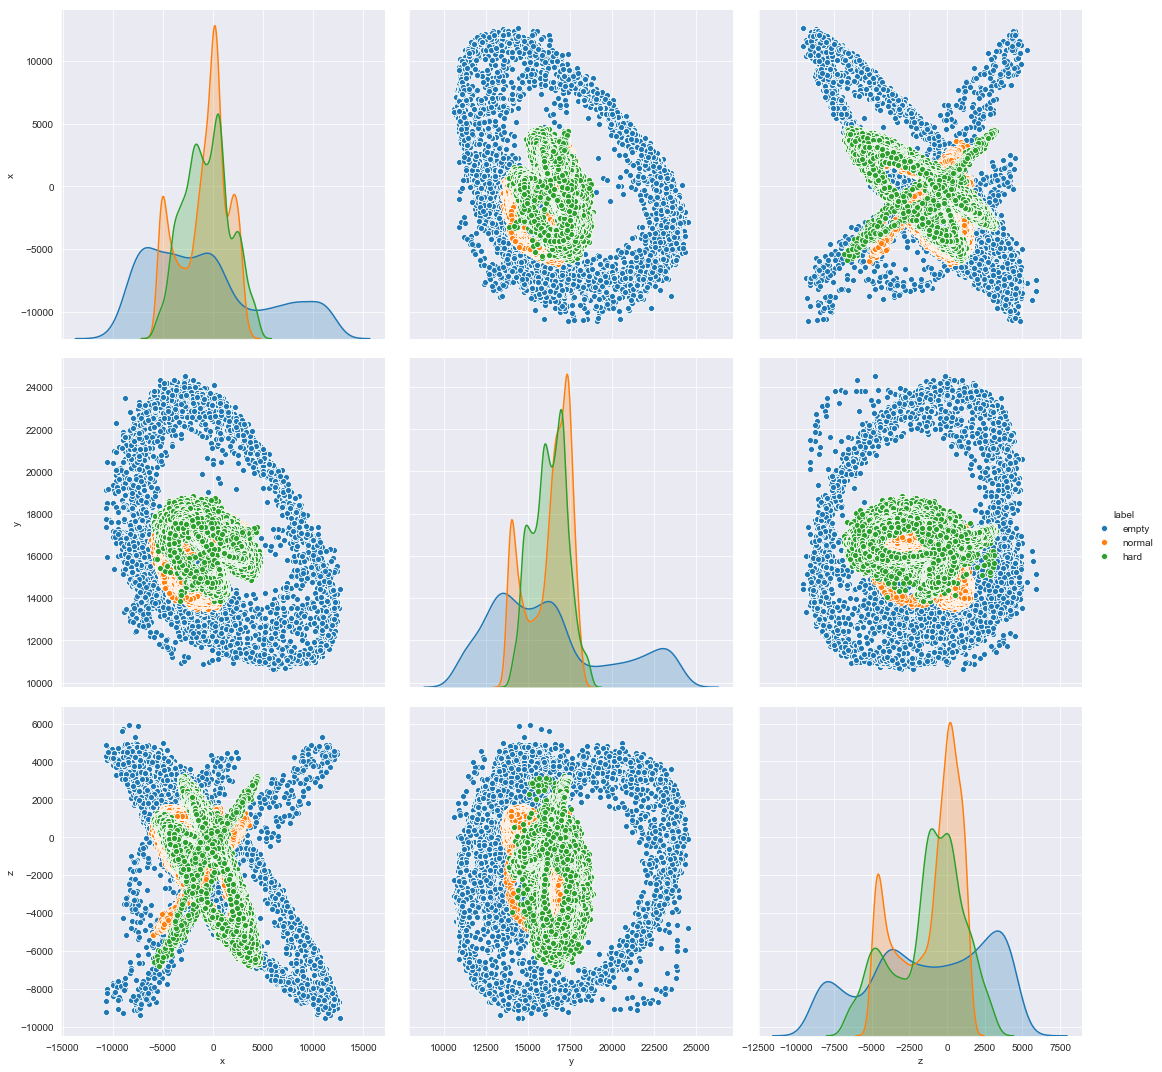

In [31]:
# rispetto alle prime tre label: empty, normal pouring, hard pouring
g = sns.pairplot(pair_df, vars=['x','y','z'], hue="label", hue_order=hue_order,
                 height=5, palette=col_labels_dict)

In [32]:
# seleziona le label per il pair plot in base a labels_dict
sel_labels = [3, 4, 7]
hue_order = [labels_dict[str(i)] for i in sel_labels]

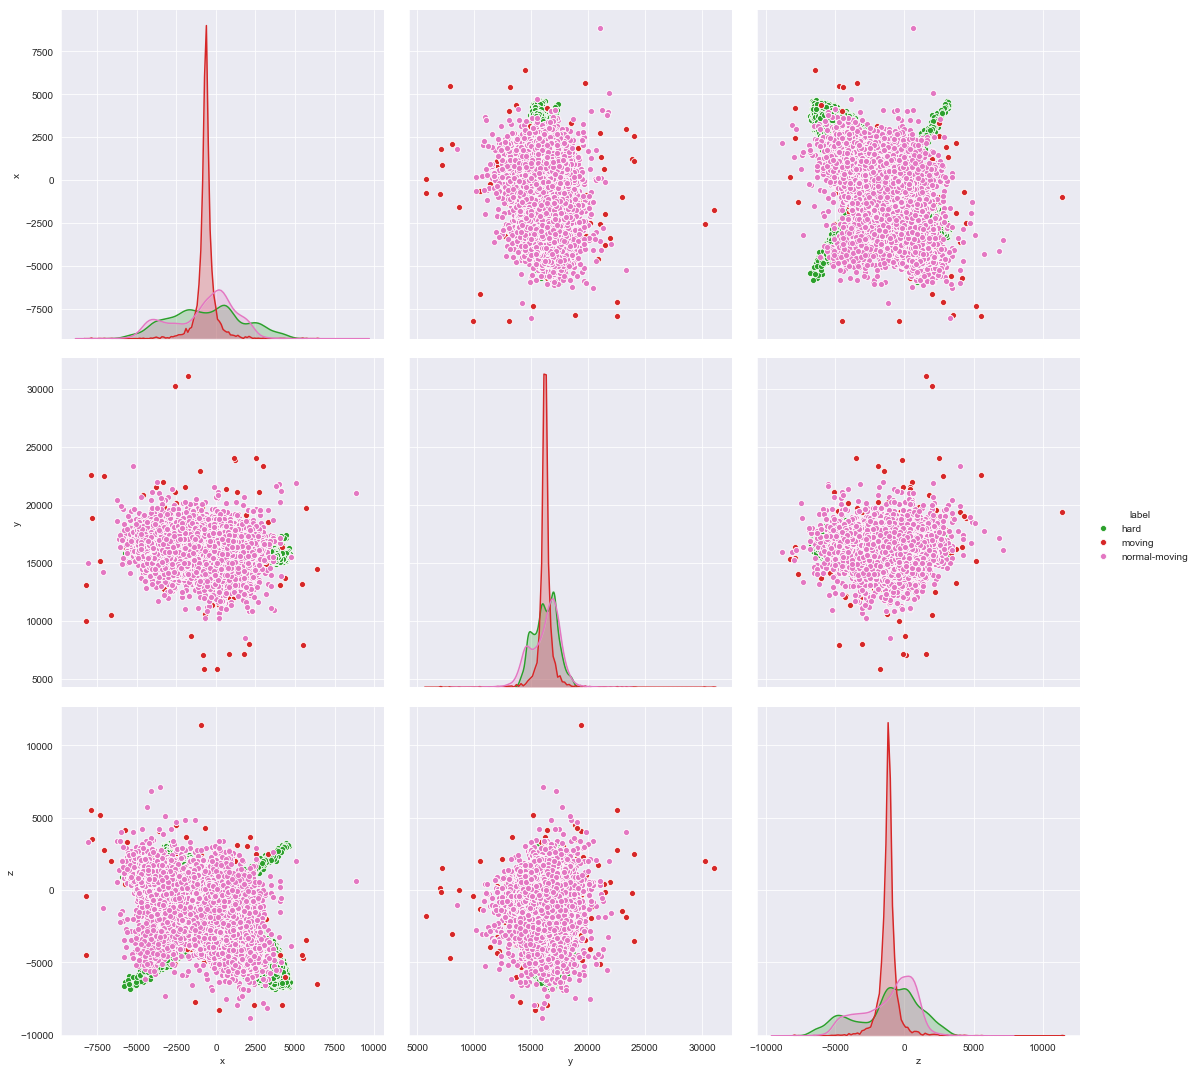

In [33]:
# rispetto alle label: hard pouring, moving, normal-moving
g = sns.pairplot(pair_df, vars=['x','y','z'], hue="label", hue_order=hue_order,
                 height=5, palette=col_labels_dict)

### Pre-processing

#### Pre-processing FFT singolo file

In [34]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [35]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

In [36]:
df = pd.read_csv(data_path + file_name, delimiter=',', header=None)

In [37]:
df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)

In [38]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [39]:
df.head(10), df.tail(10)

(                date_time     x      y     z     i
 0 2018-09-20 15:24:10.452 -7464  16632  2060  2111
 1 2018-09-20 15:24:10.456  3976  17892 -6080  2115
 2 2018-09-20 15:24:10.458  -584  17500  1356  2124
 3 2018-09-20 15:24:10.460  -584  17500  1356  2142
 4 2018-09-20 15:24:10.462  -584  17500  1356  2143
 5 2018-09-20 15:24:10.465   552  12740 -1860  2132
 6 2018-09-20 15:24:10.467   552  12740 -1860  2144
 7 2018-09-20 15:24:10.469 -7728  17280  1608  2133
 8 2018-09-20 15:24:10.471 -7728  17280  1608  2115
 9 2018-09-20 15:24:10.473  4628  17392 -6220  2097,
                     date_time     x      y     z     i
 25565 2018-09-20 15:25:11.984   224  16732   596  2217
 25566 2018-09-20 15:25:11.986 -3604  13988  1136  1975
 25567 2018-09-20 15:25:11.988 -3604  13988  1136  1807
 25568 2018-09-20 15:25:11.990  -980  17712 -3740  1760
 25569 2018-09-20 15:25:11.993  -980  17712 -3740  1937
 25570 2018-09-20 15:25:11.995  1148  16772 -2528  2176
 25571 2018-09-20 15:25:11.997  114

In [40]:
def get_signal_properties(df, start_time_idx=0, end_time_idx=len(df)):
    
    """
    calcola alcune proprietà del segnale campionato
    
    parametri:
    ----------
    df : pandas dataframe contenente una colonna di tipo datetime
    start_time_idx = indice del primo istante della finestra temporale (campione)
    end_time_idx = indice dell'utlimo istante temporale
    
    return:
    -------
    N : numero di campioni
    delta_time_sec : durata in secondi dell'intervallo di campionamento
    T : periodo = delta_time_sec/N
    fs : frequenza di campionamento = 1/T    
    """
    
    df = df[start_time_idx:end_time_idx]
    delta_time_sec = (df['date_time'][end_time_idx - 1] - df['date_time'][start_time_idx]).total_seconds()
    N = len(df)
    T = delta_time_sec/N
    fs = round(1/T, 2)
    
    return N, delta_time_sec, T, fs

In [41]:
N, delta_time_sec, T, fs = get_signal_properties(df, start_time_idx=0, end_time_idx=128)

In [42]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.313 secondi
Il periodo è: 0.0024 secondi
La frequenza di campionamento è: 408.95 Hz


In [43]:
N, delta_time_sec, T, fs = get_signal_properties(df, start_time_idx=128, end_time_idx=256)

In [44]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.289 secondi
Il periodo è: 0.0023 secondi
La frequenza di campionamento è: 442.91 Hz


Come si può osservare, il segnale è campionato in modo irregolare. Per regolarizzarlo è necessario ricampionarlo

In [45]:
df.head()

,date_time,x,y,z,i
0,2018-09-20 15:24:10.452,-7464,16632,2060,2111
1,2018-09-20 15:24:10.456,3976,17892,-6080,2115
2,2018-09-20 15:24:10.458,-584,17500,1356,2124
3,2018-09-20 15:24:10.460,-584,17500,1356,2142
4,2018-09-20 15:24:10.462,-584,17500,1356,2143


In [46]:
df_tmp = df.set_index('date_time')

In [47]:
df_tmp.head()

,x,y,z,i
date_time,,,,
2018-09-20 15:24:10.452,-7464,16632,2060,2111
2018-09-20 15:24:10.456,3976,17892,-6080,2115
2018-09-20 15:24:10.458,-584,17500,1356,2124
2018-09-20 15:24:10.460,-584,17500,1356,2142
2018-09-20 15:24:10.462,-584,17500,1356,2143


Scegliamo un intervallo di 3 ms per non discostarci troppo dal range di frequenze del campionamento originale. In ogni caso possiamo scegliere un diverso intervallo temporale

In [48]:
delta_ms = '3ms'

In [49]:
df_res = df_tmp.resample(delta_ms).asfreq().interpolate().dropna()

In [50]:
# conta il numero di NaN generati dal ricampionamento
#df_res.resample(delta_ms).asfreq().isna().sum()

In [51]:
# verifica che non ci siano NaN nel segnale ricampionato
df_res.isna().sum()

x    0
y    0
z    0
i    0
dtype: int64

In [52]:
# ritorna alla precedente struttura del df
df_res = df_res.reset_index()

In [53]:
df_res.head()

,date_time,x,y,z,i
0,2018-09-20 15:24:10.452,-7464.000000,16632.000000,2060.0,2111.000000
1,2018-09-20 15:24:10.455,-4024.000000,17066.000000,1708.0,2117.500000
2,2018-09-20 15:24:10.458,-584.000000,17500.000000,1356.0,2124.000000
3,2018-09-20 15:24:10.461,-205.333333,15913.333333,284.0,2130.666667
4,2018-09-20 15:24:10.464,173.333333,14326.666667,-788.0,2137.333333


Verifichiamo che il segnale ricampionato sia regolare prendendo diverse finestre dello stesso numero di sample

In [54]:
N, delta_time_sec, T, fs = get_signal_properties(df_res, start_time_idx=0, end_time_idx=128)

In [55]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


In [56]:
N, delta_time_sec, T, fs = get_signal_properties(df_res, start_time_idx=256, end_time_idx=384)

In [57]:
print("Il numero di sample selezionato è: {}".format(N))
print("L'intervallo temporale è: {} secondi".format(delta_time_sec))
print("Il periodo è: {} secondi".format(round(T, 4)))
print("La frequenza di campionamento è: {} Hz".format(fs))

Il numero di sample selezionato è: 128
L'intervallo temporale è: 0.381 secondi
Il periodo è: 0.003 secondi
La frequenza di campionamento è: 335.96 Hz


Applichiamo la trasformata veloce di Fourier per analizzare le componenti periodiche del segnale

In [66]:
f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [67]:
f_values.size

64

In [68]:
fft_values_ = fft(df['x'])
fft_values = 2.0/N * np.abs(fft_values_[0:N//2])

In [69]:
fft_values.size

64

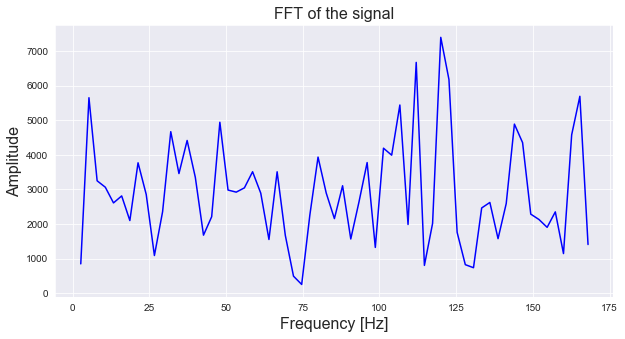

In [70]:
plt.figure(figsize=(10,5))
plt.plot(f_values[1:], fft_values[1:], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT of the signal", fontsize=16)
plt.show()

Attraverso la funzione di scipy prima (e quella di Duarte (https://bit.ly/2P5u7Ey) poi, da decommentare), individuiamo i picchi nello spazio delle frequenze che rappresentano le frequenze alle quali avvengono le oscillazioni. Tali frequenze e le relative ampiezze ci consentono di caratterizzare ciascun tipo di segnale e quindi di estrarre delle feature per l'addestramento del classificatore.

In [71]:
x, y = f_values[1:], fft_values[1:]

In [72]:
# introduciamo una soglia di ampiezza pari all'1% della differenza tra il valore max e il val min
fft_threshold = 0.01*(np.max(y) - np.min(y))

In [73]:
# nb: la distanza in questo caso è definita come numero di sample tra picchi
peaks_ind, _ = find_peaks(fft_values, threshold=fft_threshold,  distance=7)

In [74]:
peaks_ind

array([ 2, 18, 30, 38, 45, 54, 62], dtype=int64)

In [75]:
f_values[peaks_ind]

array([  5.33266675,  47.99400075,  79.99000125, 101.32066825,
       119.98500187, 143.98200225, 165.31266925])

In [76]:
fft_values[peaks_ind]

array([5651.52935467, 4942.20164179, 3935.00618047, 4192.17629518,
       7396.72382685, 4888.68817   , 5692.81366693])

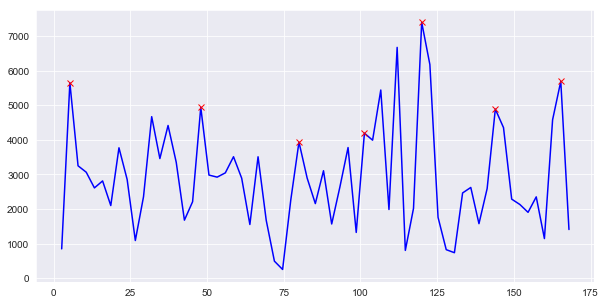

In [77]:
fig = plt.figure(figsize=(10,5))
plt.plot(x, y, 'b')
plt.plot(f_values[peaks_ind], fft_values[peaks_ind], 'x', color='r')

In [78]:
def get_first_n_peaks(x, y, n_peaks):
    
    """
    seleziona i primi n picchi del segnale trasformato,
    restituisce le frequenze dei picchi selezionati
    e le corrispondenti ampiezze
    
    parametri:
    ----------
    x : 1D array contenente le frequenze dei picchi
    y : 1D array contentente i valori di ampiezza dei picchi
    n_peaks: numero di picchi da selezionare
    
    return:
    -------
    1D array contenente i valori delle frequenze di picco scelte
    1D array contenente i valori delle corrispondenti ampiezze 
    
    """
    
    if len(x) >= n_peaks:
        
        return x[:n_peaks], y[:n_peaks]
    
    else:
        missing_n_peaks = n_peaks - len(x)
        
        peaks_x = (np.append(x[:n_peaks], np.zeros(missing_n_peaks))).astype(int)
        peaks_y = np.append(y[:n_peaks], np.zeros(missing_n_peaks))
        
        return peaks_x, peaks_y

In [79]:
peaks_x, peaks_y = get_first_n_peaks(f_values[peaks_ind], fft_values[peaks_ind], n_peaks=5)

In [80]:
peaks_x, peaks_y

(array([  5.33266675,  47.99400075,  79.99000125, 101.32066825,
        119.98500187]),
 array([5651.52935467, 4942.20164179, 3935.00618047, 4192.17629518,
        7396.72382685]))

In [81]:
# la funzione di Duarte restituisce solo l'indice dei picchi

# NB: la scala delle ascisse non corrisponde con quella reale,
# l'indice dei picchi è invece corretto e ci consente di ottenere
# il valore di ampiezza dei picchi

#ind = dpk(fft_values, mph=0, mpd=10, show=True)

In [82]:
#f_values[ind]

In [83]:
#fft_values[ind]

Definiamo delle funzioni che racchiudano gli step precedenti

In [98]:
def import_data(data_path, file_name, res=True, delta_ms='3ms'):
    
    """
    importa i dati in formato .csv in un DataFrame pandas,
    aggiunge la colonna con il modulo del segnale complessivo, 
    effettua un ricampiona
    """
    
    df = pd.read_csv(data_path + file_name, sep=',', index_col=0,
                     names=['date_time', 'x', 'y', 'z', 'i'])
    df.index = pd.to_datetime(df.index)
    df['m'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    
    if res:
        df = df.resample(delta_ms).asfreq().interpolate().dropna()
    
    return df

In [99]:
def preprocess_signal_FFT(df, var, start_idx, end_idx):
    
    """
    calcola la Fast Fourier Transform del segnale catturato
    per la variabile scelta riferita a una determinata finestra temporale;
    """
    
    df = df.reset_index()
    df = df[start_idx:end_idx]
           
    # applica la FFT al segnale
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec / N
    f = 1 / T
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(df[var])
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
      
    return f_values, fft_values

In [100]:
def plot_preprocessed_signal_FFT(x, y, color, var="", label=""):
    """
    plotta il segnale processato
    
    parametri:
    ----------
    x : 1D array, f_values
    y : 1D array, fft_values
    """
    
    x, y = x[1:], y[1:]
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x, y, linestyle='-', color=color)
    plt.xlabel('Frequency [Hz]', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    plt.title("FFT of the signal " + var + ", " + label, fontsize=16)
    plt.show()

In [183]:
data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [184]:
file_name = "3_coffee-pouring-hard-20180920--15_33_50.csv"

In [185]:
df = import_data(data_path, file_name, delta_ms='3ms')

In [104]:
f_values, fft_values = preprocess_signal_FFT(df, 'x', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

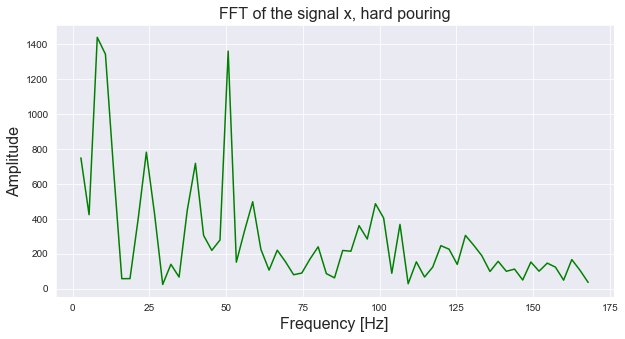

In [105]:
plot_preprocessed_signal_FFT(f_values, fft_values, var='x', color='g', label='hard pouring')

<Figure size 432x288 with 0 Axes>

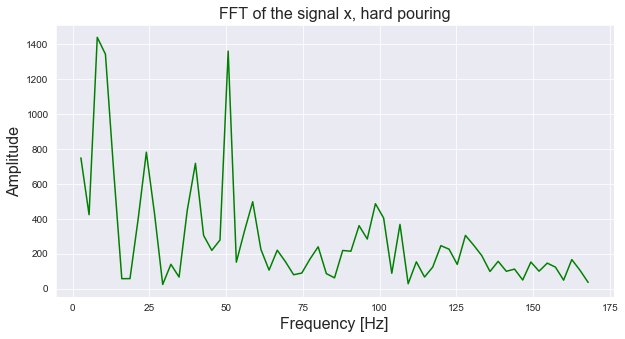

In [106]:
# in una linea
plot_preprocessed_signal_FFT(*preprocess_signal_FFT(import_data(data_path, file_name, delta_ms='3ms'),
                                var='x', start_idx=0, end_idx=128), var='x', color='g', label='hard pouring')

Il segnale, rappresentato nello spazio delle frequenze, appare molto irregolare per via del rumore presente. Occorrerà applicare dei filtri per renderlo più regolare.

Proviamo ad applicare un filtro passa-basso per rendere più smooth il segnale.

In [179]:
# crea un filtro di Butterworth di ordine 1 e cutoff a 0.2 Hz
Nf  = 1    # Filter order
Wn = 0.2 # Cutoff frequency
B, A = butter(Nf, Wn, output='ba')

In [60]:
# applica il filtro
df_res_filt_x = filtfilt(B, A, df_res['x'])

In [61]:
df_res['x_filt'] = df_res_filt_x

In [62]:
df_res.head()

,date_time,x,y,z,i,x_filt
0,2018-09-20 15:24:10.452,-7464.000000,16632.000000,2060.0,2111.000000,-7462.909731
1,2018-09-20 15:24:10.455,-4024.000000,17066.000000,1708.0,2117.500000,-4886.601198
2,2018-09-20 15:24:10.458,-584.000000,17500.000000,1356.0,2124.000000,-2717.557707
3,2018-09-20 15:24:10.461,-205.333333,15913.333333,284.0,2130.666667,-1194.502136
4,2018-09-20 15:24:10.464,173.333333,14326.666667,-788.0,2137.333333,-138.468722


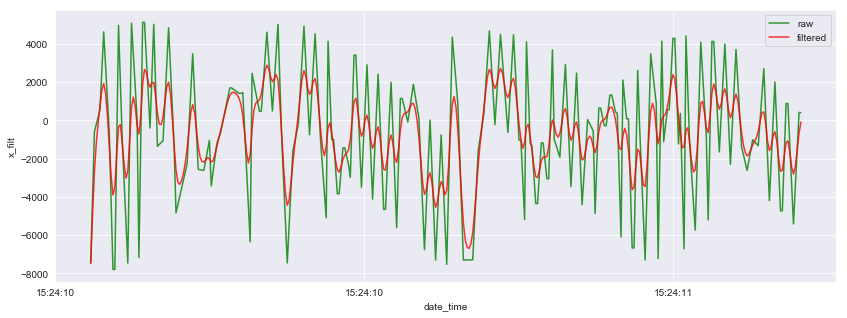

In [63]:
plt.figure(figsize=(14,5))
sns.lineplot(x='date_time', y='x', data=df_res[0:384], color='g', alpha=0.8, label='raw')
sns.lineplot(x='date_time', y='x_filt', data=df_res[0:384], color='r', alpha=0.8, label='filtered')
plt.legend()

In [94]:
f_values, fft_values = preprocess_signal_FFT(df_res, 'x', start_idx=0, end_idx=128)

In [95]:
f_values, fft_values_filt = preprocess_signal_FFT(df_res, 'x_filt', start_idx=0, end_idx=128)

In [96]:
#plot_preprocessed_signal_FFT(f_values, fft_values, var='x', color='g', label='normal pouring')
#plot_preprocessed_signal_FFT(f_values, fft_values_filt, var='x_filt', color='r', label='normal pouring')

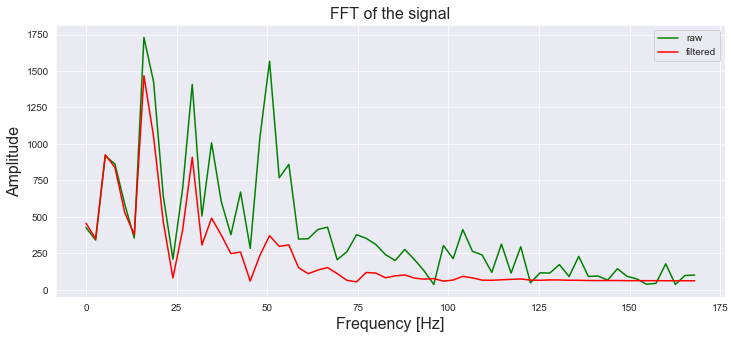

In [97]:
plt.figure(figsize=(12,5))
plt.plot(f_values, fft_values, linestyle='-', color='g', label='raw')
plt.plot(f_values, fft_values_filt, linestyle='-', color='r', label='filtered')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("FFT of the signal", fontsize=16)
plt.legend()
plt.show()

In [218]:
def filter_signal(df, Nf, Wn, var_to_filter):
    
    """
    crea un filtro di Butterworth di ordine Nf e cutoff Wn [Hz]
    
    parametri:
    ----------
    df : pandas DataFrame contenente il segnale
    Nf  : ordine del filtro
    Wn : frequenza di cutoff
    var_to_filter : variabile a cui applicare il filtro
    
    return:
    -------
    df : pandas DataFrame filtrato
    """
    
    B, A = butter(Nf, Wn, output='ba')
    df[var_to_filter+'_filtered'] = filtfilt(B, A, df[var_to_filter])
    
    return df

In [216]:
df = import_data(data_path, file_name)

In [219]:
df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')

In [221]:
df.head()

,x,y,z,i,m,x_filtered
date_time,,,,,,
2018-09-20 15:33:50.586,-1644.0,14448.0,72.0,2127.0,14541.410661,-1635.146587
2018-09-20 15:33:50.589,-1552.0,18752.0,-3692.0,2110.0,19174.907353,-986.352549
2018-09-20 15:33:50.592,630.0,17116.0,-3040.0,2120.5,17544.216335,-317.187048
2018-09-20 15:33:50.595,2812.0,15480.0,-2388.0,2131.0,15913.525317,-95.222609
2018-09-20 15:33:50.598,-1808.0,16280.0,972.0,2138.0,16408.901487,-442.995301


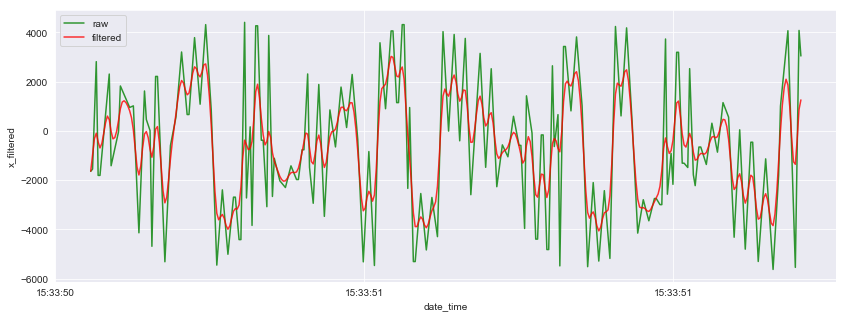

In [223]:
plt.figure(figsize=(14,5))
sns.lineplot(x='date_time', y='x', data=df.reset_index()[0:384], color='g', alpha=0.8, label='raw')
sns.lineplot(x='date_time', y='x_filtered', data=df.reset_index()[0:384], color='r', alpha=0.8, label='filtered')
plt.legend()

Decidiamo una funzione di plot generale, valida per ogni tipo di processing

In [107]:
def plot_preprocessed_signal(x, y, process, color, var="", label=""):
    """
    plotta il segnale processato
    
    parametri:
    ----------
    x : 1D array, x_values
    y : 1D array, y_values
    """
    
    xlabels = {0:'Frequency [Hz]', 1:'Frequency [Hz]', 2:'Time delay [s]'}
    ylabels = {0:'Amplitude', 1:'PSD [V**2 / Hz]', 2:'Autocorrelation amplitude'}
    titles = {0:'FFT', 1:'PSD', 2:'Autocorrelation'}
    processing_types = {'FFT':0, 'PSD':1, 'autocorr':2}
    
    x, y = x[1:], y[1:]
    
    i = processing_types[process]
    xlabel = xlabels[i]
    ylabel = ylabels[i]
    title = titles[i]
    
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))        
    ax.plot(x, y, linestyle='-', color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title+" of the signal " + var + ", " + label, fontsize=16)
    plt.show()

#### Pre-processing FFT tutti i file

In [108]:
files_list = os.listdir(data_path)

In [109]:
files_list

['1_coffee-pouring-empty-20180920--15_30_41.csv',
 '2_coffee-pouring-normal-20180920--15_24_10.csv',
 '3_coffee-pouring-hard-20180920--15_33_50.csv',
 '4_coffee-moving-20180920--15_35_14.csv',
 '5_coffee-standby-20180920--15_17_26.csv',
 '6_ coffee-steam-20180920--15_37_37.csv',
 '7_coffee-pouring-normal-moving-20180920--15_27_56.csv']

In [110]:
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

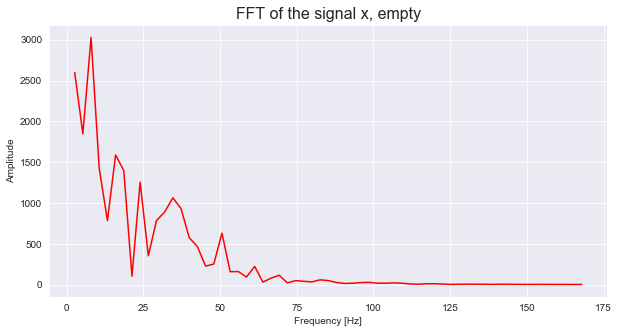

<Figure size 432x288 with 0 Axes>

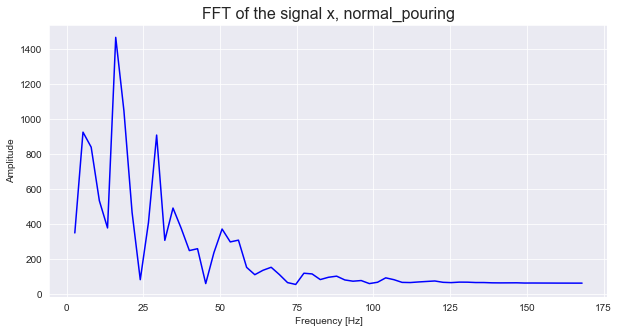

<Figure size 432x288 with 0 Axes>

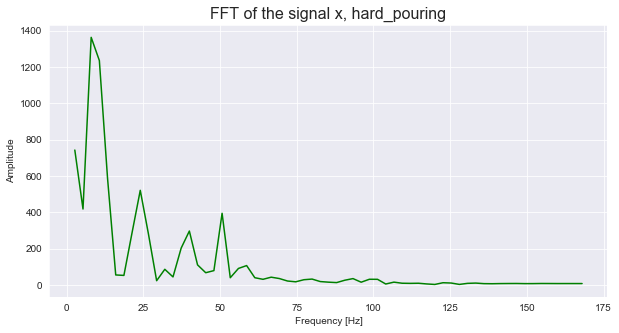

<Figure size 432x288 with 0 Axes>

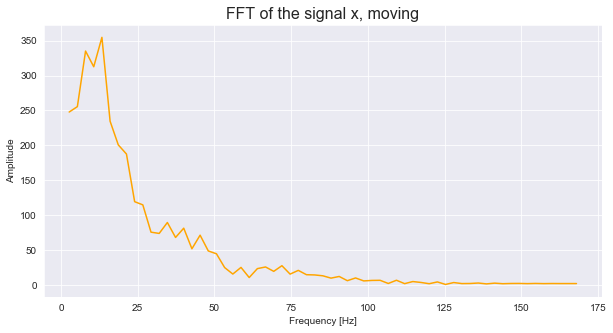

<Figure size 432x288 with 0 Axes>

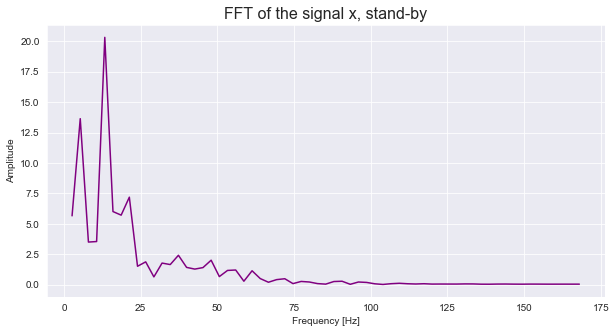

<Figure size 432x288 with 0 Axes>

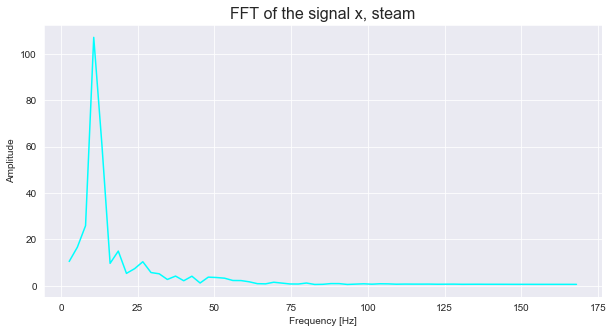

<Figure size 432x288 with 0 Axes>

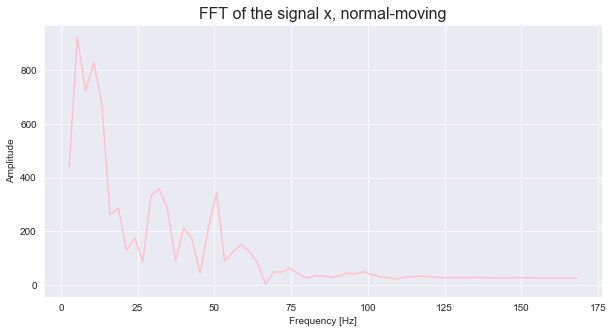

In [226]:
for f in files_list:
    file_name = f
    c = file_name[0]
    df = import_data(data_path, file_name, delta_ms='3ms')
    df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')
    x, y = preprocess_signal_FFT(df, var='x_filtered', start_idx=0, end_idx=128)
    plot_preprocessed_signal(x, y, var='x', process='FFT', color=colors[c], label=labels[c])

#### Pre-processing PSD singolo file

Similmente alla FFT, analizza lo spettro delle frequenze per calcolare la densità spettrale di potenza.

In [112]:
def preprocess_signal_PSD(df, var, start_idx, end_idx):
    
    """
    calcola la Power Spectral Density PSD del segnale catturato
    per la variabile scelta riferita a una determinata finestra temporale;
    """

    df = df.reset_index()
    df = df[start_idx:end_idx]
    
    # applica la PSD al segnale
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec / N
    f = 1 / T
    samples = end_idx-start_idx
    f_values, psd_values = welch(df[var], fs=f, nperseg=samples)
       
    return f_values, psd_values

In [113]:
file_name = '3_coffee-pouring-hard-20180920--15_33_50.csv'

In [114]:
df = import_data(data_path, file_name)

In [246]:
df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')

In [247]:
f_values, psd_values = preprocess_signal_PSD(df, var='x_filtered', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

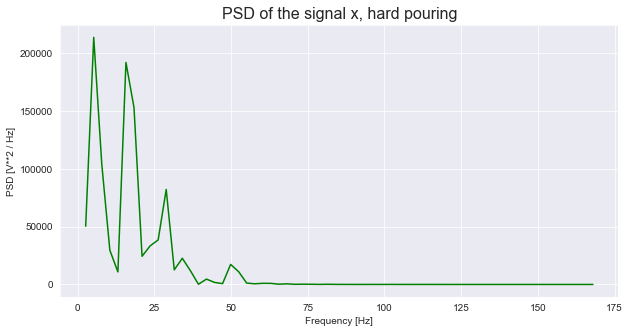

In [248]:
plot_preprocessed_signal(f_values, psd_values, process='PSD', var='x', color='g', label='hard pouring')

In [249]:
psd_threshold = 0.01*(np.max(psd_values) - np.min(psd_values))

In [260]:
# la distanza in questo caso è definita come numero di sample tra picchi
peaks_ind, _ = find_peaks(psd_values, threshold=psd_threshold, distance=4) 

In [261]:
peaks_ind

array([ 2,  6, 11, 19], dtype=int64)

In [262]:
psd_peaks = psd_values[peaks_ind]

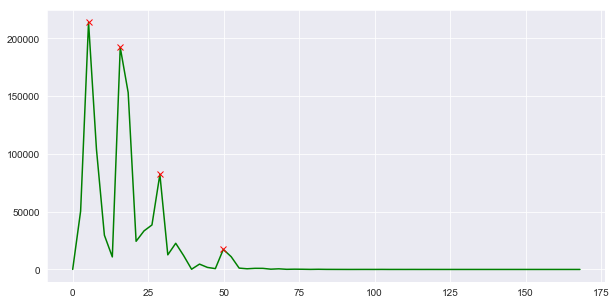

In [263]:
fig = plt.figure(figsize=(10,5))
plt.plot(f_values, psd_values, 'g')
plt.plot(f_values[peaks_ind], psd_values[peaks_ind], 'x', color='r')

In [122]:
#dpk(psd_values, mph=100000, mpd=10, threshold=0, show=True)

#### Pre-processing PSD tutti i file

In [123]:
files_list = os.listdir(data_path)
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

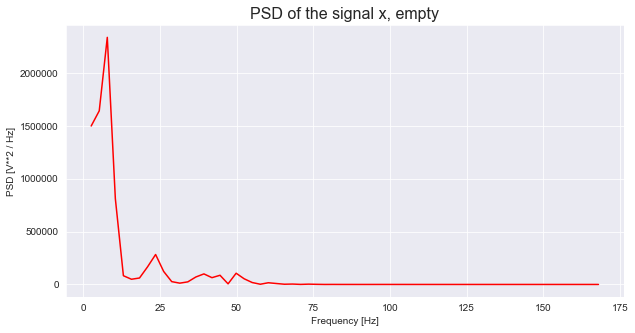

<Figure size 432x288 with 0 Axes>

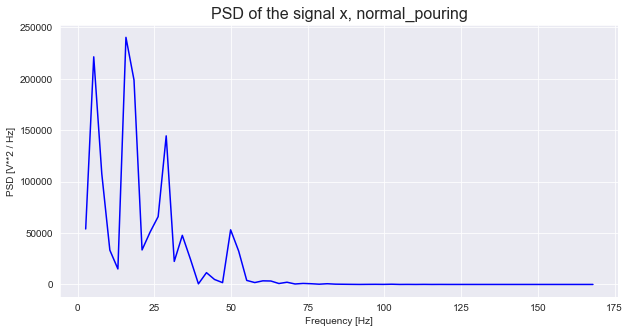

<Figure size 432x288 with 0 Axes>

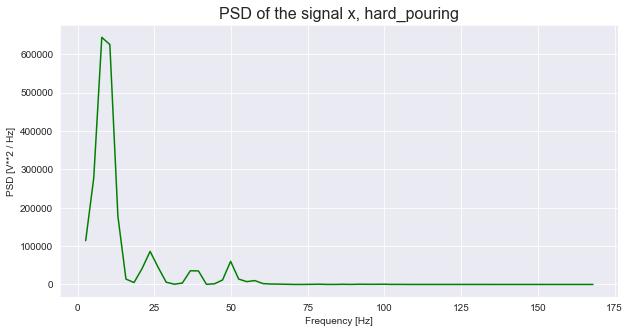

<Figure size 432x288 with 0 Axes>

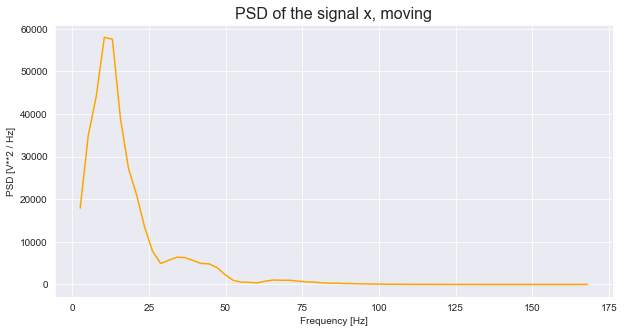

<Figure size 432x288 with 0 Axes>

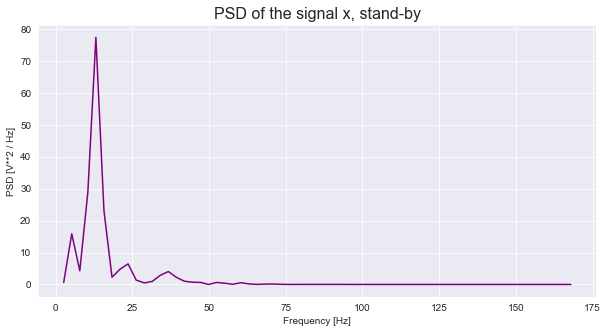

<Figure size 432x288 with 0 Axes>

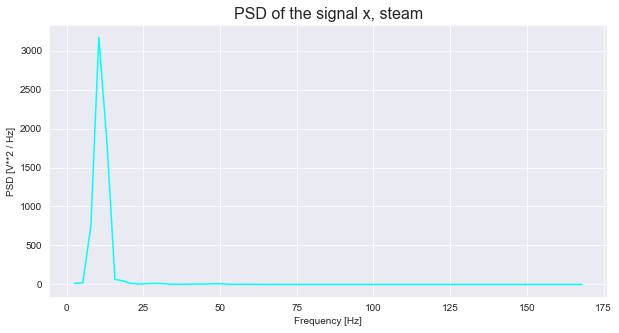

<Figure size 432x288 with 0 Axes>

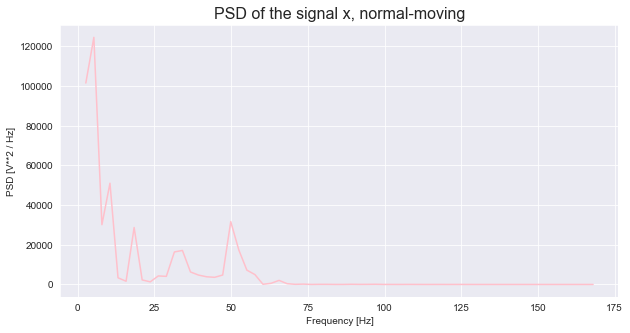

In [229]:
for f in files_list:
    file_name = f
    c = file_name[0]
    df = import_data(data_path, file_name, delta_ms='3ms')
    df = filter_signal(df, Nf=1, Wn=0.3, var_to_filter='x')
    x, y = preprocess_signal_PSD(df, var='x_filtered', start_idx=0, end_idx=128)
    plot_preprocessed_signal(x, y, var='x', process='PSD', color=colors[c], label=labels[c])

#### Pre-processing autocorrelation index singolo file

Calcola quanto il segnale è correlato con una versione "ritardata" del segnale stesso.

In [125]:
def preprocess_signal_autocorr(df, var, start_idx, end_idx):
    
    """
    calcola l'indice di autocorrelazione del segnale catturato
    per la variabile scelta riferita a una determinata finestra temporale;
    """
    
    df = df.reset_index()
    df = df[start_idx:end_idx]
    
    delta_time_sec = (df['date_time'][end_idx - 1] - df['date_time'][start_idx]).total_seconds()
    N = len(df)
    T = delta_time_sec / N
    f = 1 / T
    
    # calcola l'autocorrelation index
    result = np.correlate(df[var], df[var], mode='full')
    autocorr_values = result[result.size//2:]
    t_values = np.array([T * jj for jj in range(0, N)])
    
    return  t_values, autocorr_values

In [126]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

In [127]:
df = import_data(data_path, file_name)

In [264]:
df = filter_signal(df, Nf=1, Wn=0.3, var_to_filter='x')

In [265]:
t_values, autocorr_values = preprocess_signal_autocorr(df, var='x_filtered', start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

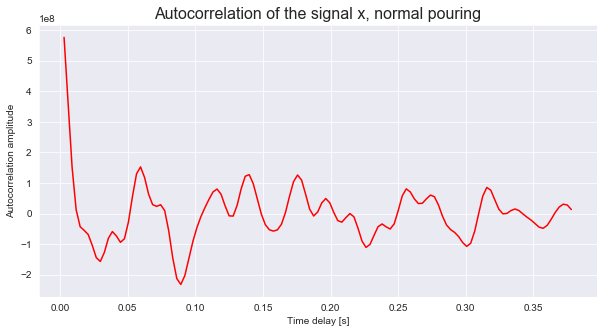

In [266]:
plot_preprocessed_signal(t_values, autocorr_values, process='autocorr', var='x', color='r', label='normal pouring')

In [ ]:
#psd_threshold = 0.01*(np.max(autocorr_values) - np.min(autocorr_values))

In [272]:
peaks_ind, _ = find_peaks(autocorr_values, threshold=None, distance=10)

In [273]:
peaks_ind

array([ 20,  47,  59,  72,  86, 106, 125], dtype=int64)

In [275]:
autocorr_peaks = autocorr_values[peaks_ind]

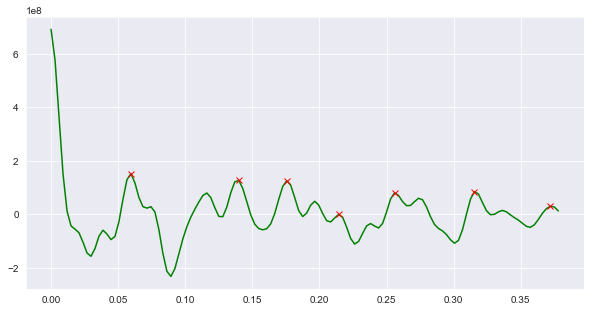

In [276]:
fig = plt.figure(figsize=(10,5))
plt.plot(t_values, autocorr_values, 'g')
plt.plot(t_values[peaks_ind], autocorr_values[peaks_ind], 'x', color='r')

#### Pre-processing autocorrelation index tutti i file

In [130]:
files_list = os.listdir(data_path)

In [131]:
colors = {'1':'red', '2':'blue', '3':'green', '4':'orange', '5':'purple', '6':'cyan', '7':'pink'}
labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
          '6':'steam', '7':'normal-moving'}

<Figure size 432x288 with 0 Axes>

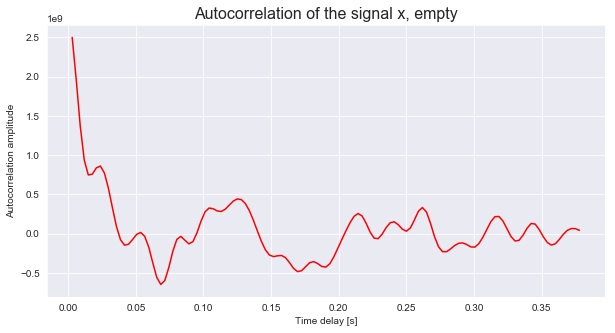

<Figure size 432x288 with 0 Axes>

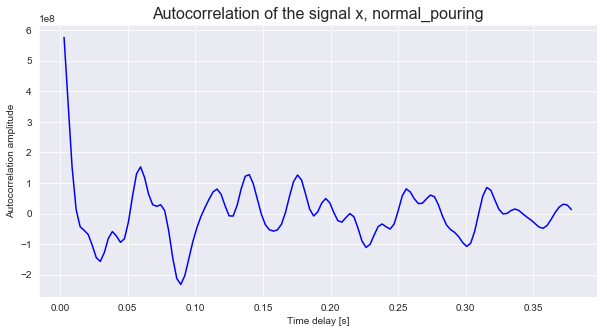

<Figure size 432x288 with 0 Axes>

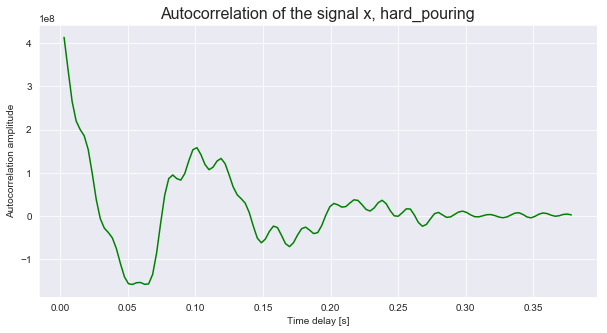

<Figure size 432x288 with 0 Axes>

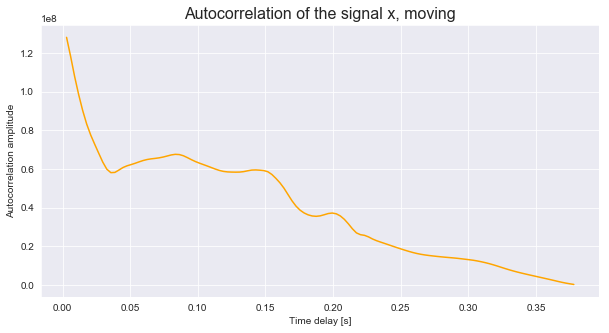

<Figure size 432x288 with 0 Axes>

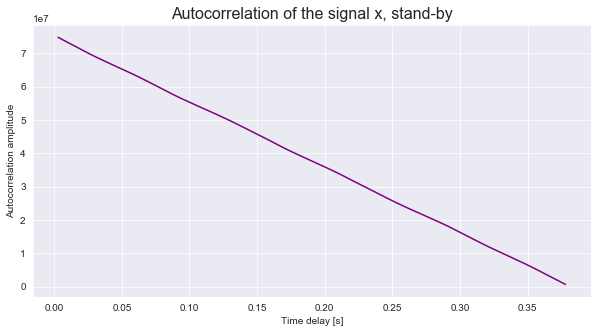

<Figure size 432x288 with 0 Axes>

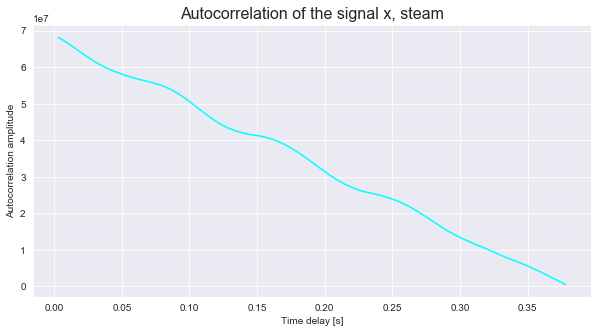

<Figure size 432x288 with 0 Axes>

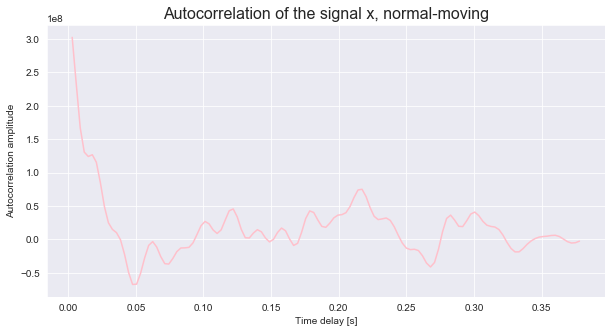

In [234]:
for f in files_list:
    file_name = f
    c = file_name[0]
    df = import_data(data_path, file_name, delta_ms='3ms')
    df = filter_signal(df, Nf=1, Wn=0.3, var_to_filter='x')
    x, y = preprocess_signal_autocorr(df, var='x_filtered', start_idx=0, end_idx=128)
    plot_preprocessed_signal(x, y, var='x', process='autocorr', color=colors[c], label=labels[c])

Condensiamo il preprocessing del segnale in un'unica funzione

In [235]:
def preprocess_signal(df, var, process, start_idx, end_idx):
    
    """
    effettua il preprocessing del segnale scelto, in base al tipo di processo
    passato come parametro, riferito alla finestra temporale selezionata

    parametri:
    ----------
    
    df : pandas DataFrame, serie storica di una o più variabili
    var : str, variabile da processare
    process : str, tipo di trasformazione
            {'FFT': Fast Fourier Transform,
             'PSD': Power Spectral Density,
             'autocorr': Autocorrelation index}
    start_idx : int, indice dell'istante iniziale
    end_idx : int, indice dell'istante finale
    
    return:
    -------
    x : x del segnale processato (frquenza o intervallo temporale)
    y : y del del segnale processato (ampiezza)
    
    """
    
    df = df.reset_index()
    df = df[start_idx:end_idx]
    
    start_time = 0
    end_time = len(df) - 1
    delta_time_sec = (df['date_time'][end_time] - df['date_time'][start_time]).total_seconds()
    N = len(df)
    T = delta_time_sec / N
    f = 1 / T
    
    if process == 'FFT':
        # applica la FFT al segnale
        f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
        fft_values_ = fft(df[var])
        fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
      
        return f_values, fft_values
    
    elif process == 'PSD':
        # applica la PSD al segnale
        samples = end_idx-start_idx
        f_values, psd_values = welch(df[var], fs=f, nperseg=samples)

        return f_values, psd_values
    
    elif process == 'autocorr':
        # calcola l'autocorrelation index
        result = np.correlate(df[var], df[var], mode='full')
        autocorr_values = result[result.size//2:]
        t_values = np.array([T * jj for jj in range(0, N)])
    
        return  t_values, autocorr_values
    
    else:
        print("Process is not valid!\n")
        print("Processes available are: 'FFT', 'PSD', 'autocorr'. Enter a valid process.")
        return False, False

In [236]:
file_name = '2_coffee-pouring-normal-20180920--15_24_10.csv'

In [237]:
df = import_data(data_path, file_name, res= True, delta_ms='3ms')

In [238]:
df = filter_signal(df, Nf=1, Wn=0.2, var_to_filter='x')

In [239]:
x, y = preprocess_signal(df, var='x_filtered', process='FFT',start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

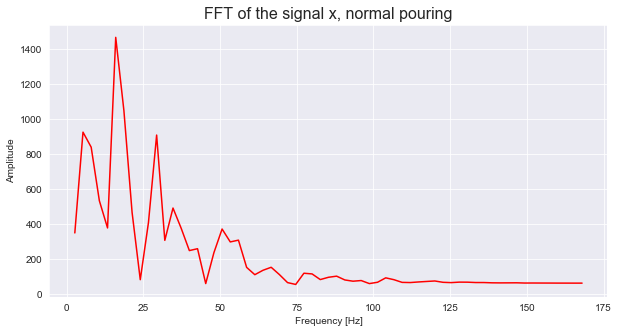

In [240]:
plot_preprocessed_signal(x, y, process='FFT', color='r', var='x', label='normal pouring')

In [241]:
x, y = preprocess_signal(df, var='x_filtered', process='PSD',start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

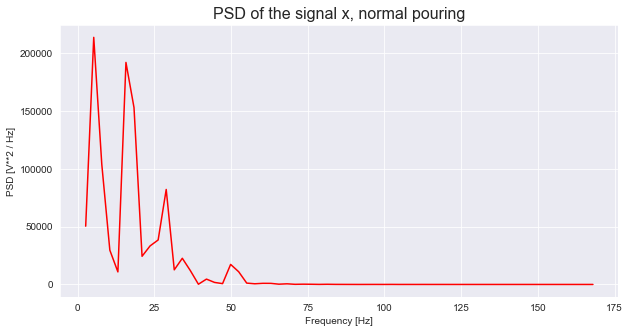

In [242]:
plot_preprocessed_signal(x, y, process='PSD', color='r', var='x', label='normal pouring')

In [243]:
x, y = preprocess_signal(df, var='x_filtered', process='autocorr',start_idx=0, end_idx=128)

<Figure size 432x288 with 0 Axes>

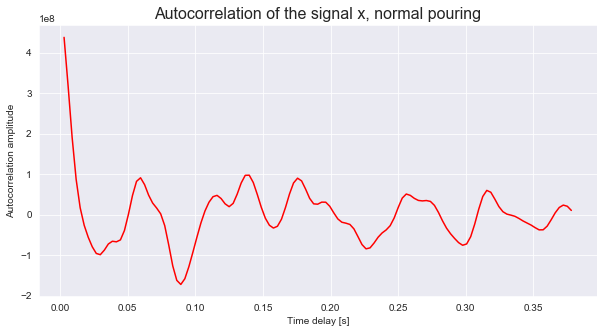

In [244]:
plot_preprocessed_signal(x, y, process='autocorr', color='r', var='x', label='normal pouring')

In [245]:
x, y = preprocess_signal(df, var='x_filtered', process='FT',start_idx=0, end_idx=128)

Process is not valid!

Processes available are: 'FFT', 'PSD', 'autocorr'. Enter a valid process.


### Data preparation for modelling

In [104]:
data_path

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\2018-09-20\\'

In [105]:
files_list

['1_coffee-pouring-empty-20180920--15_30_41.csv',
 '2_coffee-pouring-normal-20180920--15_24_10.csv',
 '3_coffee-pouring-hard-20180920--15_33_50.csv',
 '4_coffee-moving-20180920--15_35_14.csv',
 '5_coffee-standby-20180920--15_17_26.csv',
 '6_ coffee-steam-20180920--15_37_37.csv',
 '7_coffee-pouring-normal-moving-20180920--15_27_56.csv']

In [106]:
for f in files_list:
    file_name = f
    c = file_name[0]
    df = pd.read_csv(data_path + f, delimiter=',', header=None)
    print("Il file {0} contiene {1} sample".format(f, len(df)))

Il file 1_coffee-pouring-empty-20180920--15_30_41.csv contiene 10230 sample
Il file 2_coffee-pouring-normal-20180920--15_24_10.csv contiene 25575 sample
Il file 3_coffee-pouring-hard-20180920--15_33_50.csv contiene 10230 sample
Il file 4_coffee-moving-20180920--15_35_14.csv contiene 10230 sample
Il file 5_coffee-standby-20180920--15_17_26.csv contiene 51150 sample
Il file 6_ coffee-steam-20180920--15_37_37.csv contiene 15345 sample
Il file 7_coffee-pouring-normal-moving-20180920--15_27_56.csv contiene 25575 sample


Per avere lo stesso numero di sample per ogni classe, prendiamo la classe meno numerosa e selezioniamo lo stesso numero di campioni per tutte le restanti classi. Selezioniamo poi una parte di questi esempi per il training e l'altro per il testing, scegliendo uno split ratio.

In [107]:
less_num_class = 10230

Questa funzione genara un dataset con tutte le variabili.

In [108]:
def prepare_data(file_name, end_index, split_ratio):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi delle colonne
    e il formato dei dati, lo divide in due df separati secondo lo split_ratio,
    e li salva in due file .csv, uno per il training e l'altro per il testing
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal pouring', '3':'hard pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    split_index = int(end_index * split_ratio)
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df = df[0:end_index]
    
    df_train = df[0:split_index]
    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] + ".csv", sep=",",
                    index=False, encoding='utf-8')
    df_test = df[split_index:]
    df_test.to_csv(data_path+"INPUT_TEST\\" + label + "_test_" + labels[label] + ".csv", sep=",",
                   index=False, encoding='utf-8')
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)

In [ ]:
#data_path = os.getcwd() + '\\data\\2018-09-20\\'

In [ ]:
# test con un singolo file
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
prepare_data(file_name, end_index=10230, split_ratio=0.7)

In [ ]:
# per tutti i file della cartella
for f in files_list:
    
    prepare_data(f, end_index=10230, split_ratio=0.7)

Questa funzione genera un diverso dataset per ciascuna variabile.

In [109]:
def prepare_data_split_variables(file_name, end_index, split_ratio, var_to_store):
    
    """
    importa un file .csv in un df pandas, rioganizza i nomi delle colonne
    e il formato dei dati, lo divide in due df separati secondo lo split_ratio,
    e per ogni variabile genera due file .csv, uno per il training e l'altro per il testing
    """
    
    data_path = os.getcwd() + "\\data\\"
    
    labels = {'1':'empty', '2':'normal_pouring', '3':'hard_pouring', '4':'moving', '5':'stand-by', 
              '6':'steam', '7':'normal-moving'}
    label = file_name[0]
    cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}
    split_index = int(end_index * split_ratio)
    
    df = pd.read_csv(data_path + "2018-09-20\\" + file_name, sep=',', header=None)
    df.rename(columns={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}, inplace=True)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['label'] = label
    df = df[0:end_index]
    
    df_train = df[0:split_index]
    #df_train_label = df_train['label'].values
    df_train = df_train.drop('label', axis=1)

    df_train.to_csv(data_path + "INPUT_TRAIN\\" + label + "_train_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], encoding='utf-8')
    df_test = df[split_index:]
    #df_test_label = df_test['label'].values
    df_test = df_test.drop('label', axis=1)


    df_test.to_csv(data_path+"INPUT_TEST\\" + label + "_test_" + labels[label] +
                    "_" + var_to_store + "_.csv", sep=",", index=False,
                    columns=[cols[0], var_to_store], encoding='utf-8')

In [ ]:
# test con un singolo file
file_name = "2_coffee-pouring-normal-20180920--15_24_10.csv"
prepare_data_split_variables(file_name, end_index=10230, split_ratio=0.7, var_to_store='x')

In [ ]:
# per tutti i file della cartella
cols={0:'date_time', 1:'x', 2:'y', 3:'z', 4:'i'}

for f in files_list:
    
    for i in range(1,4):
        
        prepare_data_split_variables(f, end_index=10230, split_ratio=0.7, var_to_store=cols[i])

### Data reshape

Riorganizziamo i dati secondo una struttura n-dimensionale del tipo: (num segnali, num campioni, num variabili).

In [174]:
def get_input_signals(file_name, sample):
    
    """
    prende il segnale campionato e lo divide in un certo numero
    di parti sulla base del numero di campioni selezionati [sample],
    generando un df pandas di dimensioni (num segnali x num campioni)
    che contiene i valori assunti dalla variabile misurata.
    """
    
    data = pd.read_csv(file_name, sep=',', header=0)
    data.drop('date_time', axis=1, inplace=True)
    
    # riduce la lunghezza del df iniziale in modo tale che sia divisibile
    # in un numero intero di parti, dato il numero di sample scelto
    lngth = len(data) // sample * sample    
    data = data[0:lngth]
    
    data.reset_index(drop=True, inplace=True)    
    split_data = np.array_split(data, len(data)//(sample))
    
    input_signals = pd.DataFrame()

    for i in range(len(split_data)):

        data_reshaped = np.reshape(split_data[i].values, (1, -1))
        input_signals = input_signals.append(data_reshaped.tolist(), ignore_index=True)
    
    return input_signals

In [ ]:
# NB: devo ancora implementare l'overlap tra i campioni, per ora i gruppi di sample sono non sovrapposti

Test su un solo file

In [171]:
os.getcwd()

'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine'

In [172]:
data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"
FILE_NAME = "2_train_normal_pouring_x_.csv"

In [175]:
input_signals = get_input_signals(data_path+FILE_NAME, sample=128)

In [176]:
input_signals.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-7464,3976,-584,-584,-584,552,552,-7728,-7728,4628,...,492,492,-7572,-7572,5016,5016,-920,-920,-920,424
1,424,-7448,-7448,5244,5244,-1604,-1604,-1604,-168,-168,...,4352,4352,-896,-896,868,868,-7300,-7300,-7300,4468
2,-1316,-1316,572,572,-7288,-7288,4792,4792,-1560,-1560,...,-6668,2612,2612,2612,-264,-264,1112,1112,-7296,-7296
3,3480,3480,3480,-504,-504,856,856,-7220,-7220,4140,...,-40,672,672,672,-6240,-6240,2868,2868,-912,-912
4,1012,1012,-6492,-6492,-6492,3432,3432,-1392,-1392,948,...,1652,1652,-276,-276,556,556,-5496,-5496,2196,2196


In [177]:
input_signals.tail()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
50,-1136,-1136,-1648,-1648,-2692,-2692,2000,2000,2000,-852,...,2516,2516,2516,-1288,-1288,-944,-3252,-3252,2348,2348
51,2348,-1160,-1160,-1692,-1692,-2572,-2572,2004,2004,2004,...,72,72,-4288,-4288,2880,2880,-1608,-1608,-532,-532
52,-3900,-3900,-3900,2624,2624,-1220,-1220,-1000,-1000,-3228,...,3016,-1624,-1624,452,452,452,-4932,-4932,2916,2916
53,-1608,-1608,84,84,-4632,-4632,-4632,2944,2944,-1696,...,684,-5332,2788,2788,-1400,-1400,588,588,588,-4976
54,-4976,2872,2872,-1616,-1616,356,356,356,-4844,-4844,...,692,692,-5332,-5332,-5332,2660,2660,-1304,-1304,632


Test su tutti i file, per una variabile

In [177]:
def get_all_signals_labelled(files_list, var_to_extract):
    
    """
    concatena i df estratti da tutti i file (modalità di funzionamento)
    per la variabile desiderata
    """
    
    all_signals =  pd.DataFrame()

    for f in files_list:
        
        first_char = f[f.rfind('\\') +1]
        
        if first_char.isdigit() and f.endswith(".csv"):            
            signal = get_input_signals(f, sample=128)
            # aggiunge la colonnda label estraendola dal nome del file
            signal['label'] = first_char

            all_signals = pd.concat([all_signals, signal], axis=0, ignore_index=True)
            
        else:
            continue
    
    return all_signals

In [117]:
var_to_check ='x'

In [118]:
files_list = glob.glob(data_path + '*_' + var_to_check + '_*')

In [176]:
files_list

['C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\1_train_empty_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\2_train_normal_pouring_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\3_train_hard_pouring_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\4_train_moving_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\5_train_stand-by_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\6_train_steam_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\7_train_normal-moving_z_.csv',
 'C:\\Users\\Martino\\Documents\\git\\projects\\coffee_machine\\data\\INPUT_TRAIN\\windowed_signal_train_z_.csv']

In [132]:
all_x_signals = get_all_signals_labelled(files_list, 'x')

In [133]:
all_x_signals.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,5184,5184,-4908,-4908,-4908,3560,3560,-8788,-8788,5412,...,1896,-6572,-6572,2292,2292,-2716,-2716,2396,2396,1
1,-7528,-7528,-7528,3312,3312,-3420,-3420,2868,2868,-7948,...,-872,1412,-5640,-5640,-5640,904,904,-1672,-1672,1
2,1812,1812,-6416,-6416,1888,1888,1888,-2412,-2412,2312,...,-3348,1564,1564,-292,-292,-3172,-3172,-2104,-2104,1
3,620,620,620,296,296,-4424,-4424,-396,-396,-264,...,3112,3112,-3920,-3920,3380,3380,-7728,3468,-4036,1
4,-4036,3372,3372,-7616,-7616,-7616,3288,3288,-3208,-3208,...,3272,-3760,-3760,3932,3932,-8400,-8400,3484,3484,1


In [139]:
all_x_signals.tail()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
380,1044,1044,-76,-76,152,152,152,-4200,-4200,1576,...,344,228,228,-3704,164,152,152,152,216,7
381,-4252,-4252,848,848,52,52,300,300,300,-3984,...,-772,-772,-3876,-3876,-3876,-1320,-1320,72,72,7
382,72,72,-3396,-3396,-3396,-160,-160,1036,1036,912,...,-2248,-2248,944,944,248,248,248,-2316,-2316,7
383,-1088,-1088,1476,1476,492,492,-2656,-2656,-2656,-516,...,-2488,-2488,-2488,-2568,-2568,1500,1500,48,48,7
384,-1544,-1544,-1544,-1560,-1560,2204,2204,592,592,-1608,...,1444,1444,1444,96,96,-2356,-2356,-1024,-1024,7


Estraiamo i 3 df dai dati di training, uno per ciascuna variabile, e salviamoli in altrettanti file csv

In [178]:
variables = ['x', 'y', 'z']

for var in variables:
    
    data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"
    files_list = glob.glob(data_path + '*_' + var + '_*')
    
    all_signals = get_all_signals_labelled(files_list, var)
    
    all_signals.to_csv(data_path + "windowed_signal_train_" + var + 
                       "_.csv", sep=",", index=False)

Ripetiamo lo step precedente per i file della cartella TEST

In [179]:
for var in variables:
    
    data_path = os.getcwd() + "\\data\\INPUT_TEST\\"
    files_list = glob.glob(data_path + '*_' + var + '_*')
    
    all_signals = get_all_signals_labelled(files_list, var)
    
    all_signals.to_csv(data_path + "windowed_signal_test_" + var + 
                       "_.csv", sep=",", index=False)

In [184]:
data_path = os.getcwd() + "\\data\\INPUT_TRAIN\\"

In [185]:
traindf = pd.read_csv(data_path+"windowed_signal_train_z_.csv", sep=",")

In [187]:
traindf.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,5184,5184,-4908,-4908,-4908,3560,3560,-8788,-8788,5412,...,1896,-6572,-6572,2292,2292,-2716,-2716,2396,2396,1
1,-7528,-7528,-7528,3312,3312,-3420,-3420,2868,2868,-7948,...,-872,1412,-5640,-5640,-5640,904,904,-1672,-1672,1
2,1812,1812,-6416,-6416,1888,1888,1888,-2412,-2412,2312,...,-3348,1564,1564,-292,-292,-3172,-3172,-2104,-2104,1
3,620,620,620,296,296,-4424,-4424,-396,-396,-264,...,3112,3112,-3920,-3920,3380,3380,-7728,3468,-4036,1
4,-4036,3372,3372,-7616,-7616,-7616,3288,3288,-3208,-3208,...,3272,-3760,-3760,3932,3932,-8400,-8400,3484,3484,1


In [188]:
traindf.tail()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
380,-4468,-4468,-76,-76,-316,-316,372,372,372,-4624,...,-1060,-180,-180,984,-3992,-236,-236,200,1348,7
381,1348,-4624,-4624,-4624,-464,-464,-740,-740,300,300,...,1788,1788,1640,1640,1640,-2608,-2608,-1416,-1416,7
382,64,64,932,932,-4328,-4328,-4328,-2144,-2144,-1292,...,-1960,-1960,-2128,-2128,-200,-200,1192,1192,1192,7
383,-3040,-3040,-2292,-2292,-960,-960,836,836,836,-4372,...,1344,1344,-2148,-2148,-2148,-3148,-3148,-476,-476,7
384,904,904,-3152,-3152,-3152,-3460,-3460,-1276,-1276,148,...,-2684,-2684,-2684,-656,-656,384,384,-4032,-4032,7


In [181]:
testdf = pd.read_csv(data_path+"windowed_signal_test_z_.csv", sep=",")

In [182]:
testdf.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-2404,-2404,-2404,-3092,-3092,856,856,-52,-52,-3008,...,3320,3320,-2988,-2988,208,208,208,-5216,-5216,1
1,2712,2712,-1980,-1980,-1016,-1016,-1016,-4544,-4544,2268,...,3460,3460,-8460,-8460,4124,4124,4124,-3752,-3752,1
2,2604,2604,-7880,-7880,4188,4188,4188,-3324,-3324,1428,...,4676,-4044,-4044,3548,3548,-8440,-8440,-8440,4460,1
3,4460,-3852,3048,3048,-8356,-8356,-8356,3944,3944,-3456,...,4440,4440,4440,-3536,-3536,2396,2396,-8164,-8164,1
4,4276,4276,4276,-3208,-3208,1848,1848,-7212,-7212,3520,...,2092,2092,2092,-7700,-7700,3712,3712,-2904,-2904,1


In [183]:
testdf.tail()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
156,-4012,-992,-992,260,260,684,684,-4516,-4516,-4516,...,-172,-172,-2820,-2820,-2820,-2460,-2460,844,1252,7
157,1252,1252,-2380,-2380,-2000,-2000,328,328,1004,1004,...,-36,-36,-36,460,460,-2300,-2300,-3364,-3364,7
158,-208,-208,-208,424,424,-2828,-2828,-2620,-2620,436,...,-776,-4612,-4612,2596,2596,2596,572,572,172,7
159,172,-2172,-2172,-336,-336,-336,632,632,1284,1284,...,-1184,-904,-904,-88,-88,-4388,-4388,600,600,7
160,600,548,548,488,488,-3444,-3444,1132,1132,1132,...,-1560,-7816,-7816,656,656,2348,2348,1224,1224,7
